In [157]:
import itertools
import random
import string
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random as rnd
import string
from pandas import DataFrame
from math import log2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


import utils
from utils import normalizePixels, dataframe_to_array, row_to_img_grid, crop_pixel_row, apply_crop, do_nb, random_crop, \
    apply_random_image_crop


## Decision Tree


In [2]:
# reading in data

test_df = pd.read_csv('kaggleDataset/sign_mnist_test.csv')
train_df = pd.read_csv('kaggleDataset/sign_mnist_train.csv')

CLASS_COL = 'label'

print(f"Train data shape: {train_df.shape}, Test data shape: {test_df.shape}")


Train data shape: (27455, 785), Test data shape: (7172, 785)


In [3]:
# normalizing the pixel values since computation was taking a while

X_train, y_train = normalizePixels(train_df.iloc[:, 1:]), train_df.label
X_test, y_test = normalizePixels(test_df.iloc[:, 1:]), test_df.label

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_test, y_test = np.array(X_test), np.array(y_test)

# features, labels = dataframe_to_array(train_df)
# X_train, y_train = features,labels
# X_test, y_test = dataframe_to_array(test_df)

### Initial Results:

Simply training and evaluating Decision Tree model on test data results in accuracy of :

In [98]:
# fitting a basic model

initial_model = DecisionTreeClassifier()
initial_model.fit(X_train, y_train)

score = round(initial_model.score(X_test, y_test), 4)
print(f"Initial Accuracy for Decision Tree {score}")  # initial accuracy

Initial Accuracy for Decision Tree 0.4465


### Hyper parameter tuning

In [113]:
# grid search for depth, impurity, and min_samples, and splitter

param_grid = {
    'max_depth': np.arange(10, 50, step=10),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': np.arange(2, 24, step=4),
    'splitter': ['best', 'random']
}

k = 5
model = DecisionTreeClassifier()
cv = KFold(n_splits=k)
clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
clf.fit(X_train, y_train)

best_model = clf.best_estimator_
tuning_clf = clf

print("Best hyperparameters: ", clf.best_params_)


Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'splitter': 'random'}


In [116]:
# running on test set with best hyper parameters

test_score = round(best_model.score(X_test, y_test), 4)
print("Test accuracy for best model: ", test_score)


Test accuracy for best model:  0.4257


In [188]:
# analyzing the tuning results

tuning_results = pd.DataFrame(clf.cv_results_)
tuning_results = tuning_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_splitter', 'mean_test_score', 'rank_test_score']]
tuning_results['mean_test_score'] = tuning_results['mean_test_score'].round(3)

print(f"Best validation score: {tuning_results['mean_test_score'].max()} out of {len(tuning_results)} models")

n = len(tuning_results)
top_n = tuning_results.sort_values('rank_test_score')[0:n]

Best validation score: 0.907 out of 72 models


In [190]:
# select the dependent variables and the target variable
dependent_vars = ['param_max_depth', 'param_min_samples_split', 'param_splitter']
target_var = 'mean_test_score'
cmap = {'gini': 'orange', 'entropy': 'blue'}
# loop over the dependent variables and plot each one in a separate figure
# for var in dependent_vars:
#     plt.figure()
#     plt.scatter(var, target_var, data=top_n, c=top_n.param_criterion.map(cmap),)
#     plt.xlabel(var)
#     plt.ylabel(target_var)
#     legend_elements = [plt.scatter([], [], marker='o', color='orange', label='gini'),
#                        plt.scatter([], [], marker='o', color='blue', label='entropy')]
#     plt.legend(handles=legend_elements)
#     plt.show()

# visualizing boxplots of top n resulting models 
def vis_box_plots(df, x_vec, y, title='', x_labels=None, hue=None, rows=1, cols=3):
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5))

    axs[0].set_ylabel(y)
    axs[1].set_title(f'Top {n} models validation score distributions')

    for i, x in enumerate(x_vec):

        sns.boxplot(x=x, y=y,data=df, ax=axs[i], hue=hue)
        
        axs[i].set_xlabel(x_labels[i] if x_labels else '')

    plt.show()
    return fig, axs


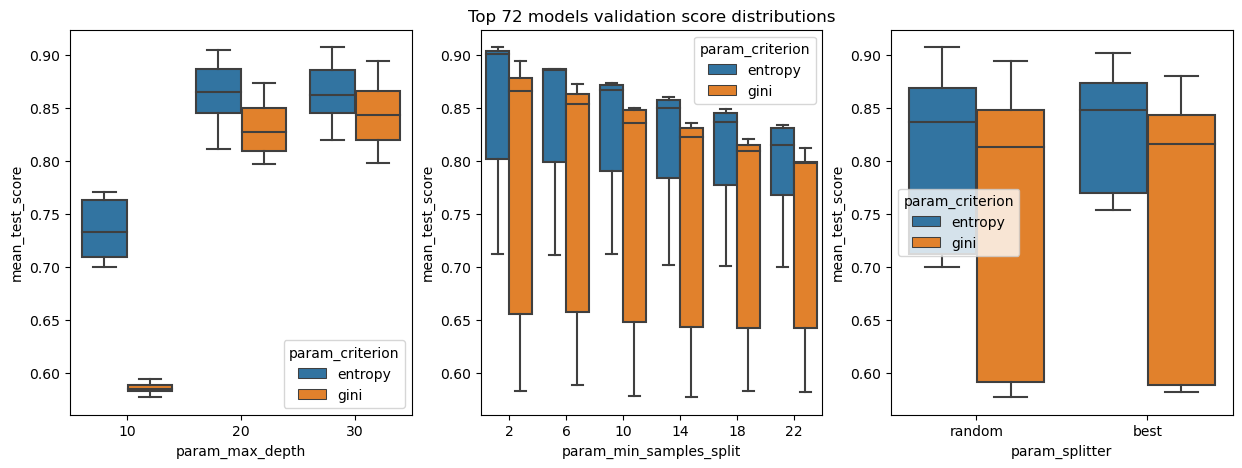

In [191]:


# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

vis_box_plots(top_n, dependent_vars, 'mean_test_score', title=f'Top {n} models validation score distributions', x_labels=dependent_vars, hue='param_criterion')
plt.show()
# sns.boxplot(x='param_max_depth', y='mean_test_score',
#             data=top_n, ax=axs[0])
# sns.boxplot(x='param_min_samples_split', y='mean_test_score',
#             data=top_n, showfliers=False, ax=axs[1])
# sns.boxplot(x='param_splitter', y='mean_test_score', hue='param_criterion',
#             data=top_n, ax=axs[2])


# axs[0].set_xlabel('param_max_depth')
# axs[0].set_ylabel('mean_test_score')
# axs[1].set_xlabel('param_min_samples_split')
# axs[2].set_xlabel('param_splitter')
# axs[1].set_title(f'Top {n} models validation score distributions')

# plt.show()


In [ ]:
# intuitive hyperparameters

# max_depth looks like everything above 20 was able to produce similar results with only 10 being significantly worse
# entropy is better than gini 

tuned_params = dict(max_depth=30, min_samples_split=12, criterion='entropy', splitter='best')
tuned_model = DecisionTreeClassifier(max_depth=tuned_params['max_depth'], min_samples_split=tuned_params['min_samples_split'], criterion=tuned_params['criterion'], splitter=tuned_params['splitter'])
tuned_model.fit(X_train, y_train)
tuned_score = tuned_model.score(X_test, y_test)

print(f"Tuned score {tuned_score:2f}")


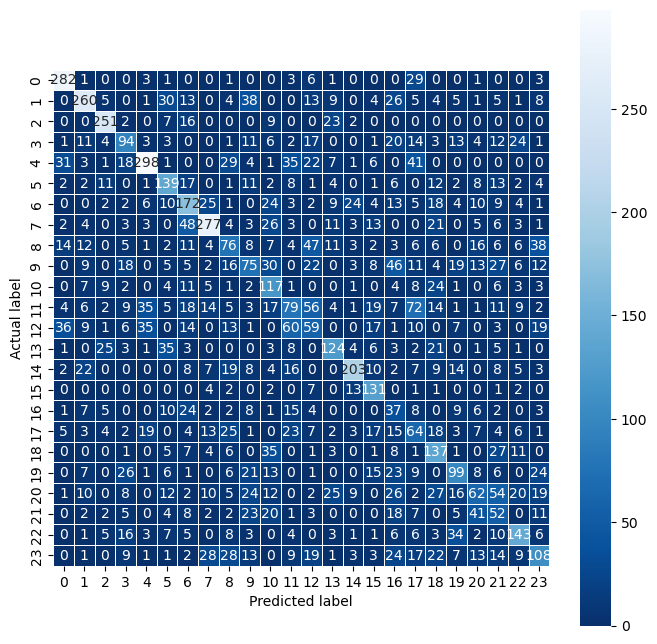

In [155]:

from sklearn.metrics import confusion_matrix


def confuse_mat(model, x, y, cmap='Blues_r'):
    preds = model.predict(x)
    cm = confusion_matrix(y_true=y, y_pred=preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, linewidths=.5, square=True, cmap=cmap, fmt='0.4g')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

confuse_mat(tuned_model, X_test, y_test)


In [158]:
# Randomized tuning with more options for min_samples split

param_grid = param_grid
param_grid['min_samples_split'] = np.arange(2, 50, step=1)

# making 100 random models
rnd_tuner = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = param_grid,  n_iter = 100, cv = 3, random_state = 42,  n_jobs = -1)
rnd_tuner.fit(X_train, y_train)

rnd_cart_cv_best_model, rnd_cart_cv_results = rnd_tuner.best_estimator_, rnd_tuner.cv_results_


In [194]:
# running on test set with best hyper parameters
test_score = round(rnd_cart_cv_best_model.score(X_test, y_test), 4)
print("Test accuracy for best model: ", test_score)

# analyzing random search hyperparameters
rnd_cart_cv_results = pd.DataFrame(rnd_tuner.cv_results_)
rnd_cart_cv_results = rnd_cart_cv_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_splitter', 'mean_test_score', 'rank_test_score']]
rnd_cart_cv_results['mean_test_score'] = rnd_cart_cv_results['mean_test_score'].round(3)

print(f"Best validation score: {rnd_cart_cv_results['mean_test_score'].max()} out of {len(rnd_cart_cv_results)} models")

n = 10
top_n = rnd_cart_cv_results.sort_values('rank_test_score')[0:n]

Test accuracy for best model:  0.4801
Best validation score: 0.877 out of 100 models


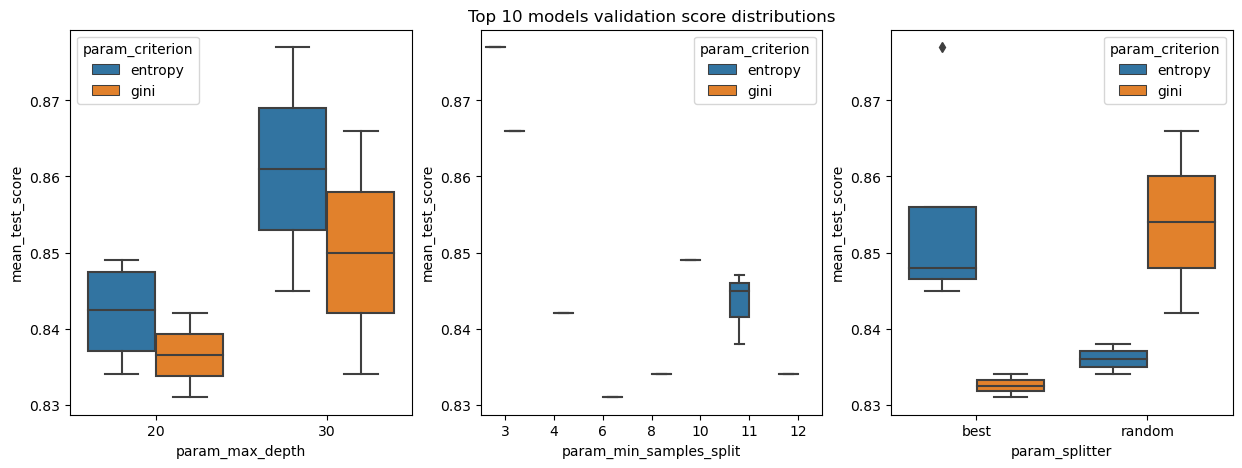

In [195]:
# box plots for rand tuner 

vis_box_plots(top_n, dependent_vars, 'mean_test_score', title=f'Top {n} models validation score distributions', x_labels=dependent_vars, hue='param_criterion')
plt.show()

In [199]:
# picking the final tuned model

tuned_params = dict(max_depth=30, min_samples_split=11, criterion='entropy', splitter='best')
tuned_model = DecisionTreeClassifier(max_depth=30, min_samples_split=3, criterion=tuned_params['criterion'], splitter=tuned_params['splitter'])
tuned_model.fit(X_train, y_train)
tuned_score = tuned_model.score(X_test, y_test)

print(f"Tuned score {round(tuned_score, 4)}")

Tuned score 0.4681


### Data augmenting


In [200]:
# cross validation to determine best uniform crop size without resizing

cropSizes = list(range(10))
scores = []

k = 5
for cropSize in cropSizes:
    filtered_x = apply_crop(X_train, crop_size=cropSize)  # cropping training data

    # training data on model with cropped data using k fold cross validation
    k_scores = cross_val_score(tuned_model, filtered_x, y_train, cv=5, n_jobs=-1)
    mean_score = k_scores.mean()
    score = round(mean_score, 4)
    scores.append(score)
    print(f"Score {score} for crop {cropSize}")

bestCropSize = cropSizes[np.argmax(scores)]


Score 0.8952 for crop 0
Score 0.8956 for crop 1
Score 0.8955 for crop 2
Score 0.8949 for crop 3
Score 0.8948 for crop 4


Best crop size: 1, Best Validation accuracy 0.896


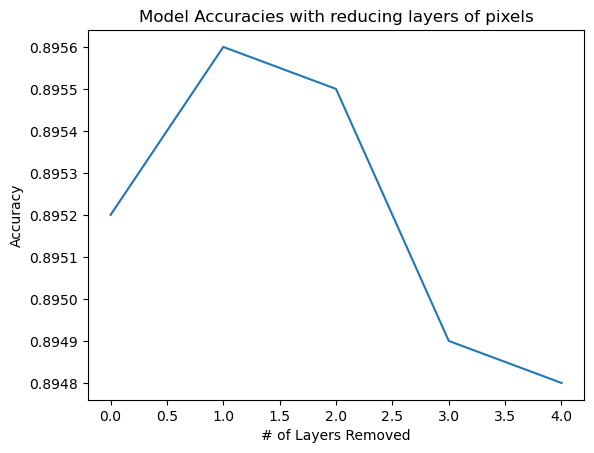

In [204]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Model Accuracies with reducing layers of pixels")
plt.xlabel('# of Layers Removed')
plt.ylabel("Accuracy")
plt.plot(cropSizes, scores)

In [205]:
# applying best crop size to test set

# best cropsize is 0
filtered_x_train = apply_crop(X_train, crop_size=bestCropSize)
filtered_x_test = apply_crop(X_test, crop_size=bestCropSize)
tuned_model.fit(filtered_x_train, y_train)

best_test_accuracy = round(tuned_model.score(filtered_x_test, y_test), 4)

print(f"Best test accuracy with symmetric image crop of {bestCropSize}: {best_test_accuracy} ||| best validation {round(max(scores), 3)}")


Best test accuracy with symmetric image crop of 1: 0.4757 ||| best validation 0.896


### Random Crop Image Augmentation

We will attempt to randomly crop the images with a fixed crop size and then resize them back to original dimensions. Algorithm basically chooses a random point to begin crop from and generates a cropped image based on some crop_width and crop_height. This experiment will only do square crops. Will use k-fold cross validation to test different sizes. keep in mind original images are 28x28

In [222]:
# random crop augmentation , usually takes about 5 mins to run
cropSizes = list(range(1, 28, 3))
scores = []
k = 5
for cropSize in cropSizes:
    fold_scores = []
    filtered_x = apply_random_image_crop(X_train, cropSize, cropSize)
    for i in range(k):
        tuned_model = DecisionTreeClassifier(max_depth=30, min_samples_split=3, criterion=tuned_params['criterion'], splitter=tuned_params['splitter'])

        # splitting int o train and validation
        split_x = np.array([filtered_x[j] for j in range(len(filtered_x)) if j % k != i])
        split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k != i])
        validation_split_x = np.array([X_train[j] for j in range(len(X_train)) if j % k == i])
        validation_split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k == i])

        # training and scoring model
        tuned_model.fit(split_x, split_y)
        score = tuned_model.score(validation_split_x, validation_split_y)

        fold_scores.append(score)
    scores.append(np.mean(fold_scores))

bestCropSize = cropSizes[np.argmax(scores)]

Best crop size: 25, Best Validation accuracy 0.155
[0.04873429247860135, 0.03831724640320524, 0.04367146239300674, 0.04432708067747223, 0.05346931342196322, 0.05798579493716991, 0.07284647605172098, 0.09677654343471134, 0.1545437989437261]


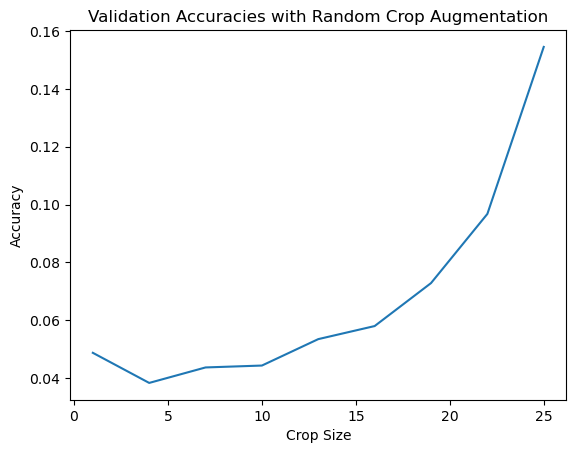

In [223]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Validation Accuracies with Random Crop Augmentation")
plt.xlabel('Crop Size')
plt.ylabel("Accuracy")
plt.plot(cropSizes, scores)
print(scores)

In [224]:
# random crop image for model

# pretty shit for random image cropping 

cropped_train = apply_random_image_crop(X_train, bestCropSize, bestCropSize)
tuned_model.fit(cropped_train, y_train)
best_random_crop_acc = tuned_model.score(X_test, y_test)

print(f"Best random crop ({bestCropSize}) test accuracy : {round(best_random_crop_acc, 4)}")

Best random crop (25) test accuracy : 0.1531


### Random Forest

In [221]:
# Initialize a random forest classifier with 100 trees
from sklearn.ensemble import RandomForestClassifier


initial_rfc = RandomForestClassifier()

# Fit the random forest classifier to the dataset
initial_rfc.fit(X_train, y_train)
inital_acc = initial_rfc.score(X_test, y_test)

print(f"Initial Random Forest Acc: {inital_acc:.4f}") # initila was 0.82

Initial Random Forest Acc: 0.8178
